<a href="https://colab.research.google.com/github/neo09sumedh/BERT-LLM/blob/main/Project_Phase_2_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertForSequenceClassification, AdamW
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd

# Ensure you have a GPU available for faster training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Step 1: Load and preprocess the dataset
# Example: Load a CSV dataset with 'text' and 'label' columns
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)  # Replace with your dataset
texts = df[0].tolist()
labels = df[1].tolist()

In [3]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
# Dataset Preparation
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [5]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)


train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
# Step 2: Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # Adjust num_labels based on classes
model.to(device)

# Step 3: Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 4  # Assume 4 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()
epoch_tr_loss,epoch_test_loss = [],[]
train_losses = []
train_acc = 0.0
# Step 4: Training Loop
epochs = 4
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")
    test_losses = []
    test_acc = 0.0
    total_test_loss = 0
    for batch in test_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_test_loss += loss.item()
        test_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Epoch Test {epoch + 1}/{epochs}, Loss: {total_test_loss / len(test_loader)}")
    epoch_train_loss = np.mean(train_losses)
    epoch_test_loss = np.mean(test_losses)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_test_loss.append(epoch_test_loss)
# Step 5: Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        #accuracy = accuracy_score(predictions, true_labels)
        #print(f"Accuracy: {accuracy}")

print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"]))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Loss: 0.3743840013819106
Epoch Test 1/4, Loss: 0.25498966373845766
Epoch 2/4, Loss: 0.10806469800289871
Epoch Test 2/4, Loss: 0.06703669712182948
Epoch 3/4, Loss: 0.023292228054306387
Epoch Test 3/4, Loss: 0.012942949788987466
Epoch 4/4, Loss: 0.007145659224368427
Epoch Test 4/4, Loss: 0.00864357750691559
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       671
    Positive       1.00      1.00      1.00       713

    accuracy                           1.00      1384
   macro avg       1.00      1.00      1.00      1384
weighted avg       1.00      1.00      1.00      1384



[0.0015799343818798661, 0.0029678046703338623, 0.003371175844222307, 0.0016900828341022134, 0.0013043214567005634, 0.001372019061818719, 0.43857309222221375, 0.0011582819279283285, 0.0016603032127022743, 0.0033977064304053783, 0.0017424407415091991, 0.004684509709477425, 0.0035653486847877502, 0.006080955732613802, 0.002278885804116726, 0.0015828226460143924, 0.002335147699341178, 0.003096839878708124, 0.002539871260523796, 0.0016093626618385315, 0.0035327153746038675, 0.004282391630113125, 0.0025224576238542795, 0.0021188044920563698, 0.017585191875696182, 0.0013952824519947171, 0.0016764773754402995, 0.004017331637442112, 0.005367585923522711, 0.001953729195520282, 0.007398297544568777, 0.004582085646688938, 0.001437281141988933, 0.00270149577409029, 0.00383117888122797, 0.0011821435764431953, 0.008377348072826862, 0.016069680452346802, 0.008466308936476707, 0.003864949569106102, 0.0018992474069818854, 0.006483127363026142, 0.005904268939048052, 0.002031231764703989, 0.00136955583002

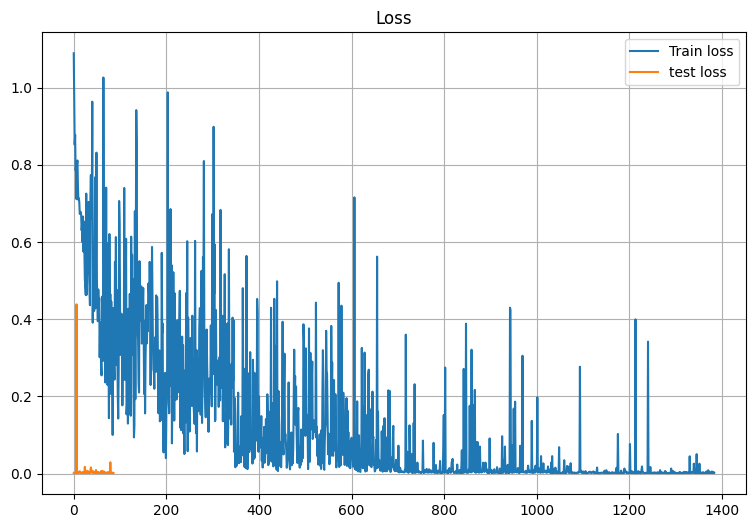

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='test loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


In [24]:
model.save_pretrained("bert-sentiment")
tokenizer.save_pretrained("bert-sentiment")


('bert-sentiment/tokenizer_config.json',
 'bert-sentiment/special_tokens_map.json',
 'bert-sentiment/vocab.txt',
 'bert-sentiment/added_tokens.json')

In [26]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

model = BertForSequenceClassification.from_pretrained("bert-sentiment")
tokenizer = BertTokenizer.from_pretrained("bert-sentiment")
model.to(device)

# Inference Function
def predict_sentiment(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_label = torch.argmax(probabilities, dim=-1).item()

    # Label mapping
    label_map = {0: "Negative", 1: "Positive"}
    sentiment = label_map[predicted_label]
    return sentiment, probabilities.cpu().numpy()

# Example usage
texts = [
    "I love this product, it's amazing!",
    "This is the worst experience I've ever had.",
    "Movie is great",
    "I hate screen"
]

for text in texts:
    sentiment, probabilities = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nSentiment: {sentiment}\nProbabilities: {probabilities}\n")


Text: I love this product, it's amazing!
Sentiment: Positive
Probabilities: [[1.0811986e-04 9.9955827e-01 3.3357841e-04]]

Text: This is the worst experience I've ever had.
Sentiment: Negative
Probabilities: [[9.989791e-01 3.544036e-04 6.665534e-04]]

Text: Movie is great
Sentiment: Positive
Probabilities: [[1.1970989e-04 9.9961865e-01 2.6155924e-04]]

Text: I hate screen
Sentiment: Negative
Probabilities: [[9.9911731e-01 7.2181906e-04 1.6088599e-04]]

